In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master("local[*]").getOrCreate()

# Reading Spark metrics

The benchmark is configured to collect event logs in text files.  We can then process these with Spark.

In [40]:
import glob

glob.glob("local-*")

['local-1491590798166', 'local-1491917985726', 'local-1491920268540']

We'll need to denormalize Spark events so that we can identify tasks by the stages they're associated with, and then ascribe metrics to particular call sites in our program.

In [41]:
df = spark.read.json("local-1491920268540")
tm = df.select("Task Info", "Task Metrics").na.drop().select("Task Info.*", "Task Metrics.*")

# select stage names and IDs from stage-submitted events
stageNames = df.filter(df["Event"] == "SparkListenerStageSubmitted").select(df["Stage Info.Stage ID"].alias("Stage ID"), df["Stage Info.Stage Name"].alias("Stage Name"))

# identify task IDs associated with each stage
tasksForStages = df.filter(df["Event"] == "SparkListenerTaskStart").select("Stage ID", df["Task Info.Task ID"].alias("Task ID"))

# identify metrics associated with each task ID
metricsForTasks = tm.join(tasksForStages, tasksForStages["Task ID"] == tm["Task ID"])

# join metrics for each task with the stage containing that task
metricsForStages = metricsForTasks.join(stageNames, metricsForTasks["Stage ID"] == stageNames["Stage ID"])

Note that this application only launches Spark jobs from two call sites.

In [42]:
metricsForStages.select("Stage Name").distinct().show()

+--------------------+
|          Stage Name|
+--------------------+
|treeAggregate at ...|
|repartition at Ma...|
+--------------------+



In [54]:
from pyspark.sql.functions import avg, variance, column, max
metricsForStages.groupBy("Stage Name").agg(avg(column("JVM GC Time")), max(column("JVM GC Time"))).show()

+--------------------+-----------------+----------------+
|          Stage Name| avg(JVM GC Time)|max(JVM GC Time)|
+--------------------+-----------------+----------------+
|treeAggregate at ...|36.62546816479401|            2857|
|repartition at Ma...|             36.0|              36|
+--------------------+-----------------+----------------+



In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
sns.set(color_codes=True)

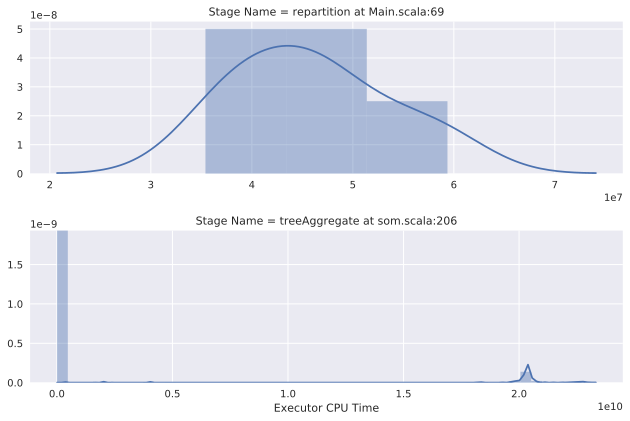

In [44]:
g = sns.FacetGrid(metricsForStages.toPandas(), row="Stage Name", sharex=False, sharey=False, aspect=3)
_ = g.map(sns.distplot, "Executor CPU Time")

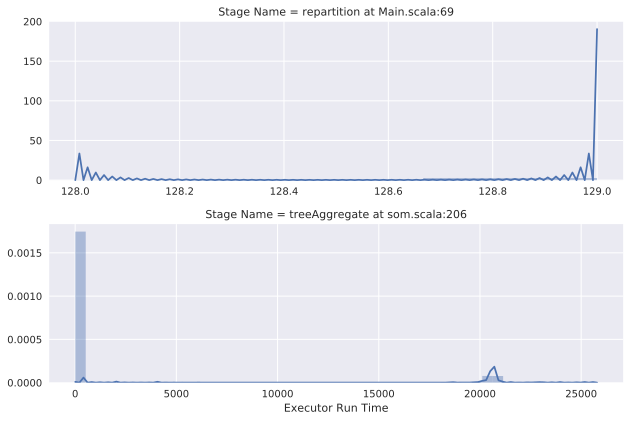

In [45]:
g2 = sns.FacetGrid(metricsForStages.toPandas(), row="Stage Name", sharex=False, sharey=False, aspect=3)
_ = g2.map(sns.distplot, "Executor Run Time")

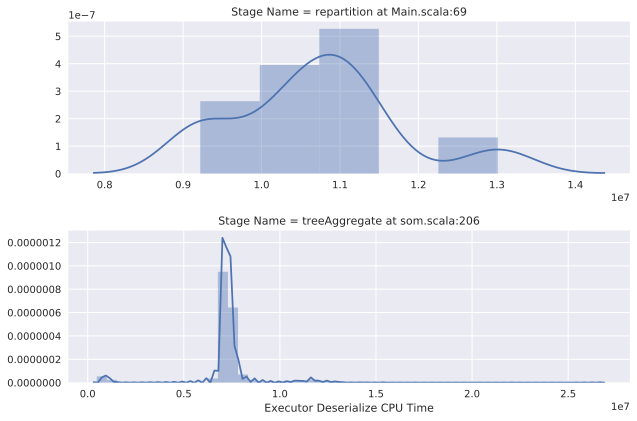

In [46]:
g3 = sns.FacetGrid(metricsForStages.toPandas(), row="Stage Name", sharex=False, sharey=False, aspect=3)
_ = g3.map(sns.distplot, "Executor Deserialize CPU Time")

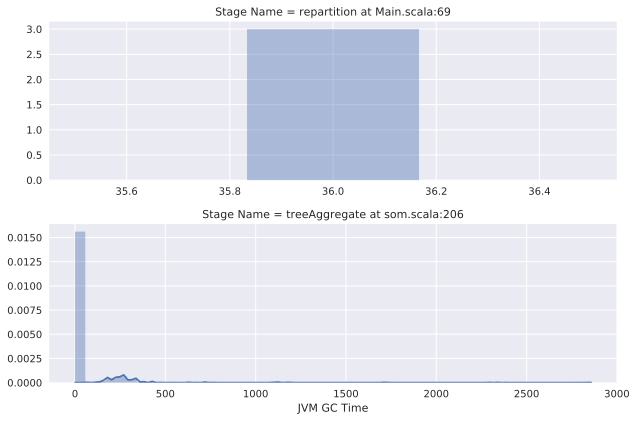

In [47]:
g4 = sns.FacetGrid(metricsForStages.toPandas(), row="Stage Name", sharex=False, sharey=False, aspect=3)
_ = g4.map(sns.distplot, "JVM GC Time")